In [ ]:
import os
import openai
import sqlite3
import numpy as np
import pandas as pd
from google.colab import userdata
import wandb

oai_token = userdata.get('OPENAI_API_KEY')

oai = openai.OpenAI(api_key=oai_token)
onet = sqlite3.connect("onet.database") # Run ./create_onet_database.sh to create it
# This dataset comes from https://epoch.ai/gradient-updates/consequences-of-automating-remote-work
# It contains labels for whethere a O*NET task can be done remotely or not (labeled by GPT-4o)
# You can download it here: https://drive.google.com/file/d/1GrHhuYIgaCCgo99dZ_40BWraz-fzo76r/view?usp=sharing
df_remote_status = pd.read_csv("epoch_task_data.csv")

# BLS OEWS: https://www.bls.gov/oes/special-requests/oesm23nat.zip
df_oesm = pd.read_excel("oesm23national.xlsx")

# Run uv run enrich_task_ratings.py to get this file
df = pd.read_json("task_ratings_enriched.json")

In [ ]:
df = pd.merge(df, df_remote_status[['Task', 'Remote']], left_on='task', right_on='Task', how='left')
df = df.drop('Task', axis=1) \
       .rename(columns={'Remote': 'remote_status'})
df

onetsoc_code  task_id  \
0       11-1011.00     8823   
1       11-1011.00     8824   
2       11-1011.00     8827   
3       11-1011.00     8826   
4       11-1011.00     8834   
...            ...      ...   
39462   53-7121.00    12807   
39463   53-7121.00    12804   
39464   53-7121.00    12803   
39465   53-7121.00    12805   
39466   53-7121.00    12810   

                                                    task  \
0      Direct or coordinate an organization's financi...   
1      Confer with board members, organization offici...   
2      Prepare budgets for approval, including those ...   
3      Direct, plan, or implement policies, objective...   
4      Prepare or present reports concerning activiti...   
...                                                  ...   
39462  Unload cars containing liquids by connecting h...   
39463  Clean interiors of tank cars or tank trucks, u...   
39464  Lower gauge rods into tanks or read meters to ...   
39465  Operate conveyors and equipment to transfer gr...   
39466  Perform general warehouse activities, such as ...   

                        occupation_title  \
0                       Chief Executives   
1                       Chief Executives   
2                       Chief Executives   
3                       Chief Executives   
4                       Chief Executives   
...                                  ...   
39462  Tank Car, Truck, and Ship Loaders   
39463  Tank Car, Truck, and Ship Loaders   
39464  Tank Car, Truck, and Ship Loaders   
39465  Tank Car, Truck, and Ship Loaders   
39466  Tank Car, Truck, and Ship Loaders   

                                  occupation_description  \
0      Determine and formulate policies and provide o...   
1      Determine and formulate policies and provide o...   
2      Determine and formulate policies and provide o...   
3      Determine and formulate policies and provide o...   
4      Determine and formulate policies and provide o...   
...                                                  ...   
39462  Load and unload chemicals and bulk solids, suc...   
39463  Load and unload chemicals and bulk solids, suc...   
39464  Load and unload chemicals and bulk solids, suc...   
39465  Load and unload chemicals and bulk solids, suc...   
39466  Load and unload chemicals and bulk solids, suc...   

       frequency_category_1  frequency_category_2  frequency_category_3  \
0                      5.92                 15.98                 29.68   
1                      1.42                 14.44                 27.31   
2                     15.50                 38.21                 32.73   
3                      3.03                 17.33                 20.30   
4                      1.98                 14.06                 42.60   
...                     ...                   ...                   ...   
39462                  6.05                 29.21                  6.88   
39463                  1.47                  6.33                 21.70   
39464                  4.52                  1.76                  4.65   
39465                  6.97                 12.00                  2.52   
39466                  5.91                 10.85                  6.46   

       frequency_category_4  frequency_category_5  frequency_category_6  \
0                     21.18                 19.71                  4.91   
1                     25.52                 26.88                  2.52   
2                      5.15                  5.25                  0.19   
3                     18.10                 33.16                  2.01   
4                     21.24                 13.18                  6.24   
...                     ...                   ...                   ...   
39462                 13.95                 27.65                  7.93   
39463                 25.69                 32.35                 12.47   
39464                 17.81                 37.42                 23.31   
39465      

In [ ]:
FREQUENCY_MAP = {
    'frequency_category_1': "Yearly or less",
    'frequency_category_2': "More than yearly",
    'frequency_category_3': "More than monthly",
    'frequency_category_4': "More than weekly",
    'frequency_category_5': "Daily",
    'frequency_category_6': "Several times daily",
    'frequency_category_7': "Hourly or more"
}

In [ ]:
# Cross-reference woth BLS OEWS
# It doesn't really make sens to have it per-task, we only need it per-occupation...
df_oesm_detailed = df_oesm[df_oesm['O_GROUP'] == 'detailed'][['OCC_CODE', 'TOT_EMP', 'H_MEAN', 'A_MEAN']].copy()
df['occ_code_join'] = df['onetsoc_code'].str[:7]
df = pd.merge(
    df,
    df_oesm_detailed,
    left_on='occ_code_join',
    right_on='OCC_CODE',
    how='left'
)
df = df.drop(columns=['occ_code_join']).rename(columns={"OCC_CODE": "occ_code", "TOT_EMP": "total_employment", "H_MEAN": "hourly_wage_average", "A_MEAN": "annual_wage_average"})

In [ ]:
remote_df = df[df['remote_status'] == 'remote'].copy()
remote_df

onetsoc_code  task_id  \
0       11-1011.00     8823   
1       11-1011.00     8824   
2       11-1011.00     8827   
3       11-1011.00     8826   
4       11-1011.00     8834   
...            ...      ...   
39438   53-7081.00     7172   
39442   53-7081.00     7178   
39443   53-7081.00     7179   
39447   53-7081.00     7183   
39455   53-7121.00    12796   

                                                    task  \
0      Direct or coordinate an organization's financi...   
1      Confer with board members, organization offici...   
2      Prepare budgets for approval, including those ...   
3      Direct, plan, or implement policies, objective...   
4      Prepare or present reports concerning activiti...   
...                                                  ...   
39438              Fill out defective equipment reports.   
39442  Communicate with dispatchers concerning delays...   
39443  Check road or weather conditions to determine ...   
39447          Organize schedules for refuse collection.   
39455  Record operating data such as products and qua...   

                                occupation_title  \
0                               Chief Executives   
1                               Chief Executives   
2                               Chief Executives   
3                               Chief Executives   
4                               Chief Executives   
...                                          ...   
39438  Refuse and Recyclable Material Collectors   
39442  Refuse and Recyclable Material Collectors   
39443  Refuse and Recyclable Material Collectors   
39447  Refuse and Recyclable Material Collectors   
39455          Tank Car, Truck, and Ship Loaders   

                                  occupation_description  \
0      Determine and formulate policies and provide o...   
1      Determine and formulate policies and provide o...   
2      Determine and formulate policies and provide o...   
3      Determine and formulate policies and provide o...   
4      Determine and formulate policies and provide o...   
...                                                  ...   
39438  Collect and dump refuse or recyclable material...   
39442  Collect and dump refuse or recyclable material...   
39443  Collect and dump refuse or recyclable material...   
39447  Collect and dump refuse or recyclable material...   
39455  Load and unload chemicals and bulk solids, suc...   

       frequency_category_1  frequency_category_2  frequency_category_3  \
0                      5.92                 15.98                 29.68   
1                      1.42                 14.44                 27.31   
2                     15.50                 38.21                 32.73   
3                      3.03                 17.33                 20.30   
4                      1.98                 14.06                 42.60   
...                     ...                   ...                   ...   
39438                  0.00                  1.75                  9.69   
39442                  0.00                  1.04                  5.92   
39443                  0.00                  8.98                  4.23   
39447                 11.57                 25.97                 14.88   
39455                  0.00                  2.49                  2.07   

       frequency_category_4  frequency_category_5  frequency_category_6  \
0                     21.18                 19.71                  4.91   
1                     25.52                 26.88                  2.52   
2                      5.15                  5.25                  0.19   
3                     18.10                 33.16                  2.01   
4                     21.24                 13.18                  6.24   
...                     ...                   ...                   ...   
39438                  3.08                 85.29                  0.09   
39442                  3.74                 69.00                

In [ ]:
# We sample a N unique occupations to have about a thousands associated tasks
unique_occ_code = remote_df['occ_code'].unique()
np.random.shuffle(unique_occ_code)
unique_occ_code = unique_occ_code[:25]
remote_sample_df = remote_df[remote_df['occ_code'].isin(unique_occ_code)]

print("Sample size: ", len(remote_sample_df))

Sample size:  1599


In [ ]:
from google.colab import files

remote_sample_df.to_csv('df_sample.csv', encoding = 'utf-8-sig')
files.download('df_sample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run `uv run add_task_estimates_to_samples.py` (this calls OpenAI and might be costly), then import the df_sample.csv again, it has two new columns lb_estimate and ub_estimate.

In [ ]:
enriched_sample_df = pd.read_csv("df_sample_with_estimates.csv")
enriched_sample_df.keys()

Index(['Unnamed: 0', 'onetsoc_code', 'task_id', 'task', 'occupation_title',
       'occupation_description', 'frequency_category_1',
       'frequency_category_2', 'frequency_category_3', 'frequency_category_4',
       'frequency_category_5', 'frequency_category_6', 'frequency_category_7',
       'importance_average', 'relevance_average', 'remote_status', 'occ_code',
       'total_employment', 'hourly_wage_average', 'annual_wage_average',
       'lb_estimate', 'ub_estimate'],
      dtype='object')

In [ ]:
import pandas as pd
from google.colab import files

sdf = df[df['remote_status'] == 'remote'].sample(frac=1, random_state=42)  # frac=1 shuffles all rows
sample_tasks = sdf.iloc[:45]
tasks_df = sample_tasks[['task', 'occupation_title', 'occupation_description']].copy()
tasks_df.to_csv('sampled_tasks.csv', index=False)
files.download('sampled_tasks.csv')

In [ ]:
DURATION_TO_HOUR_ESTIMATE = {
    '10 minutes': 0.1,
    '30 minutes': .5,
    '1 hour': 1,
    '4 hours': 4,
    '8 hours': 8,
    '16 hours': 16,
    '3 days': 72,
    '1 week': 168,
    '3 weeks': 504,
    '6 weeks': 1008,
    '3 months': 3 * (365.25 / 12) * 24,
    '6 months': 6 * (365.25 / 12) * 24,
    '1 year': 1 * 365.25 * 24,
    '3 years': 3 * 365.25 * 24,
    '10 years': 10 * 365.25 * 24,
    '30 years': 10 * 365.25 * 24,
    '60 years': 10 * 365.25 * 24,
}

enriched_sample_df['lb_estimate_in_hours'] = enriched_sample_df['lb_estimate'].map(DURATION_TO_HOUR_ESTIMATE)
enriched_sample_df['ub_estimate_in_hours'] = enriched_sample_df['ub_estimate'].map(DURATION_TO_HOUR_ESTIMATE)
enriched_sample_df

Unnamed: 0 onetsoc_code  task_id  \
0           362   11-3071.00    21343   
1           363   11-3071.00    21344   
2           364   11-3071.00    21345   
3           366   11-3071.00    21347   
4           368   11-3071.00    21349   
..          ...          ...      ...   
747       35501   49-1011.00    15264   
748       35502   49-1011.00     2926   
749       35503   49-1011.00     2931   
750       35504   49-1011.00     2932   
751       36002   49-3093.00     8383   

                                                  task  \
0    Plan, organize, or manage the work of subordin...   
1    Collaborate with other departments to integrat...   
2    Analyze all aspects of corporate logistics to ...   
3    Develop and document standard and emergency op...   
4    Analyze the financial impact of proposed logis...   
..                                                 ...   
747  Review, evaluate, accept, and coordinate compl...   
748  Compile operational or personnel records, such...   
749  Develop or implement electronic maintenance pr...   
750  Design equipment configurations to meet person...   
751             Order replacements for tires or tubes.   

                                      occupation_title  \
0    Transportation, Storage, and Distribution Mana...   
1    Transportation, Storage, and Distribution Mana...   
2    Transportation, Storage, and Distribution Mana...   
3    Transportation, Storage, and Distribution Mana...   
4    Transportation, Storage, and Distribution Mana...   
..                                                 ...   
747  First-Line Supervisors of Mechanics, Installer...   
748  First-Line Supervisors of Mechanics, Installer...   
749  First-Line Supervisors of Mechanics, Installer...   
750  First-Line Supervisors of Mechanics, Installer...   
751                        Tire Repairers and Changers   

                                occupation_description  frequency_category_1  \
0    Plan, direct, or coordinate transportation, st...                  0.00   
1    Plan, direct, or coordinate transportation, st...                  3.33   
2    Plan, direct, or coordinate transportation, st...                 10.00   
3    Plan, direct, or coordinate transportation, st...                 23.81   
4    Plan, direct, or coordinate transportation, st...                  3.45   
..                                                 ...                   ...   
747  Directly supervise and coordinate the activiti...                  4.43   
748  Directly supervise and coordinate the activiti...                  4.25   
749  Directly supervise and coordinate the activiti...                  3.26   
750  Directly supervise and coordinate the activiti...                  6.07   
751                          Repair and replace tires.                  5.26   

     frequency_category_2  frequency_category_3  frequency_category_4  ...  \
0                    0.00                  3.10                  7.15  ...   
1                    6.67                 33.33                 10.00  ...   
2                   13.33                 20.00                 26.67  ...   
3                   23.81                 28.57                  9.52  ...   
4                   27.59                 34.48                 31.03  ...   
..                    ...                   ...                   ...  ...   
747                 14.98                 44.06                  9.94  ...   
748                  6.22                 27.27                 16.93  ...   
749                  3.23                  9.64                 18.78  ...   
750                 10.37                 42.18                 22.01  ...   
751                  4.94                  9.61                  7.48  ...   

     relevance_average  remote_status  occ_code  total_employment  \
0                97.17         remote   11-3071          198780.0   
1               100.00         remote   11-3071          198780.0   
2            

In [ ]:
hardest_task_df = enriched_sample_df.loc[enriched_sample_df.groupby('occupation_title')['ub_estimate_in_hours'].idxmax()]
hardest_task_df

Unnamed: 0 onetsoc_code  task_id  \
142        5334   23-1021.00     7627   
698       32910   41-3011.00     4593   
676       31849   35-3011.00     2241   
714       33264   43-3031.00     2488   
682       32364   39-3092.00     9631   
738       34247   45-2093.00    13426   
65         2965   17-2111.02     8990   
749       35503   49-1011.00     2931   
125        4770   19-4043.00    22270   
81         4274   19-2042.00    19769   
56         2946   17-2111.00    21877   
97         4390   19-3032.00     7567   
740       34749   47-2132.00    13560   
651       26473   25-2012.00     6519   
359       20317   25-1112.00     6222   
140        5069   21-1013.00     9196   
132        4965   19-5012.00    11097   
674       31127   31-9095.00     2057   
736       33799   43-5051.00    20905   
670       29100   27-4014.00    18661   
31          403   11-3071.04    15692   
706       33145   41-9041.00     4618   
739       34499   47-2044.00     2854   
751       36002   49-3093.00     8383   
2           364   11-3071.00    21345   
118        4534   19-3051.00      233   
70         3846   19-1023.00    23958   

                                                  task  \
142  Determine existence and amount of liability ac...   
698  Identify new advertising markets, and propose ...   
676                              Create drink recipes.   
714  Comply with federal, state, and company polici...   
682          Recommend vendors and monitor their work.   
738  Maintain growth, feeding, production, and cost...   
65   Study the relationships between ignition sourc...   
749  Develop or implement electronic maintenance pr...   
125  Interview individuals, and research public dat...   
81   Research geomechanical or geochemical processe...   
56       Develop industry standards of product safety.   
97   Formulate and implement training programs, app...   
740  Read blueprints and specifications to determin...   
651  Collaborate with other teachers and administra...   
359  Maintain regularly scheduled office hours to a...   
140  Provide public education and consultation to o...   
132  Prepare documents to be used in legal proceedi...   
674  Prepare, maintain, and record records of inven...   
736  Order retail items and other supplies for offi...   
670  Convert video and audio recordings into digita...   
31   Develop or implement procedures or systems to ...   
706  Deliver prepared sales talks, reading from scr...   
739  Prepare cost and labor estimates, based on cal...   
751             Order replacements for tires or tubes.   
2    Analyze all aspects of corporate logistics to ...   
118  Supervise or coordinate the work of urban plan...   
70                         Conduct literature reviews.   

                                      occupation_title  \
142  Administrative Law Judges, Adjudicators, and H...   
698                           Advertising Sales Agents   
676                                         Bartenders   
714       Bookkeeping, Accounting, and Auditing Clerks   
682                                 Costume Attendants   
738  Farmworkers, Farm, Ranch, and Aquacultural Ani...   
65            Fire-Prevention and Protection Engineers   
749  First-Line Supervisors of Mechanics, Installer...   
125  Geological Technicians, Except Hydrologic Tech...   
81   Geoscientists, Except Hydrologists and Geograp...   
56   Health and Safety Engineers, Except Mining Saf...   
97             Industrial-Organizational Psychologists   
740                     Insulation Workers, Mechanical   
651    Kindergarten Teachers, Except Special Education   
359                        Law Teachers, Postsecondary   
140                     Marriage and Family Therapists   
132         Occupational Health and Safety Technicians   
674                                     Pharmacy Aides   
736                              Postal Service Clerks   
670                      Sound Engineering Technicians   
31           

In [ ]:
enriched_sample_df

Unnamed: 0 onetsoc_code  task_id  \
0           362   11-3071.00    21343   
1           363   11-3071.00    21344   
2           364   11-3071.00    21345   
3           366   11-3071.00    21347   
4           368   11-3071.00    21349   
..          ...          ...      ...   
747       35501   49-1011.00    15264   
748       35502   49-1011.00     2926   
749       35503   49-1011.00     2931   
750       35504   49-1011.00     2932   
751       36002   49-3093.00     8383   

                                                  task  \
0    Plan, organize, or manage the work of subordin...   
1    Collaborate with other departments to integrat...   
2    Analyze all aspects of corporate logistics to ...   
3    Develop and document standard and emergency op...   
4    Analyze the financial impact of proposed logis...   
..                                                 ...   
747  Review, evaluate, accept, and coordinate compl...   
748  Compile operational or personnel records, such...   
749  Develop or implement electronic maintenance pr...   
750  Design equipment configurations to meet person...   
751             Order replacements for tires or tubes.   

                                      occupation_title  \
0    Transportation, Storage, and Distribution Mana...   
1    Transportation, Storage, and Distribution Mana...   
2    Transportation, Storage, and Distribution Mana...   
3    Transportation, Storage, and Distribution Mana...   
4    Transportation, Storage, and Distribution Mana...   
..                                                 ...   
747  First-Line Supervisors of Mechanics, Installer...   
748  First-Line Supervisors of Mechanics, Installer...   
749  First-Line Supervisors of Mechanics, Installer...   
750  First-Line Supervisors of Mechanics, Installer...   
751                        Tire Repairers and Changers   

                                occupation_description  frequency_category_1  \
0    Plan, direct, or coordinate transportation, st...                  0.00   
1    Plan, direct, or coordinate transportation, st...                  3.33   
2    Plan, direct, or coordinate transportation, st...                 10.00   
3    Plan, direct, or coordinate transportation, st...                 23.81   
4    Plan, direct, or coordinate transportation, st...                  3.45   
..                                                 ...                   ...   
747  Directly supervise and coordinate the activiti...                  4.43   
748  Directly supervise and coordinate the activiti...                  4.25   
749  Directly supervise and coordinate the activiti...                  3.26   
750  Directly supervise and coordinate the activiti...                  6.07   
751                          Repair and replace tires.                  5.26   

     frequency_category_2  frequency_category_3  frequency_category_4  ...  \
0                    0.00                  3.10                  7.15  ...   
1                    6.67                 33.33                 10.00  ...   
2                   13.33                 20.00                 26.67  ...   
3                   23.81                 28.57                  9.52  ...   
4                   27.59                 34.48                 31.03  ...   
..                    ...                   ...                   ...  ...   
747                 14.98                 44.06                  9.94  ...   
748                  6.22                 27.27                 16.93  ...   
749                  3.23                  9.64                 18.78  ...   
750                 10.37                 42.18                 22.01  ...   
751                  4.94                  9.61                  7.48  ...   

     relevance_average  remote_status  occ_code  total_employment  \
0                97.17         remote   11-3071          198780.0   
1               100.00         remote   11-3071          198780.0   
2            

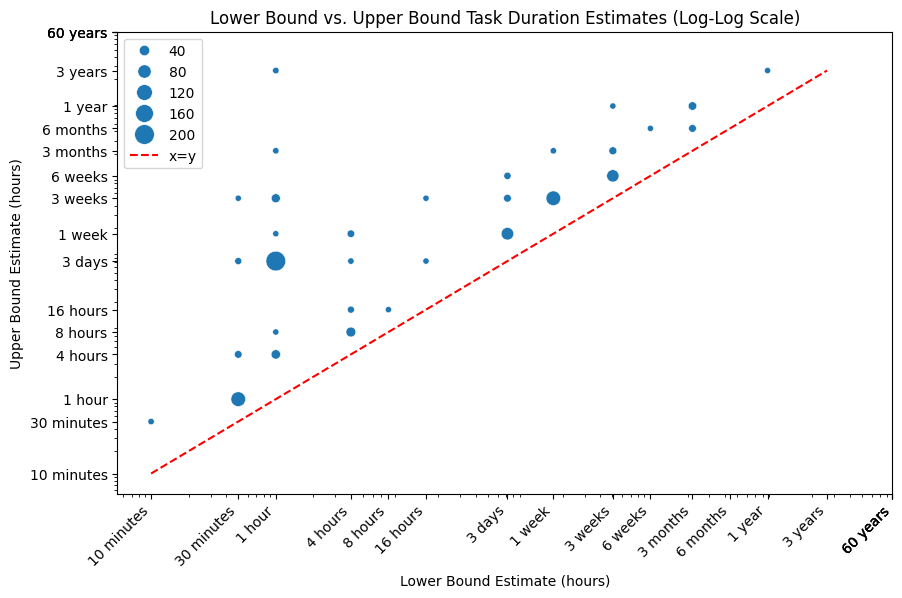

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

DURATION_TO_HOUR_ESTIMATE = {
    '10 minutes': 0.1,
    '30 minutes': .5,
    '1 hour': 1,
    '4 hours': 4,
    '8 hours': 8,
    '16 hours': 16,
    '3 days': 72,
    '1 week': 168,
    '3 weeks': 504,
    '6 weeks': 1008,
    '3 months': 3 * (365.25 / 12) * 24,
    '6 months': 6 * (365.25 / 12) * 24,
    '1 year': 1 * 365.25 * 24,
    '3 years': 3 * 365.25 * 24,
    '10 years': 10 * 365.25 * 24,
    '30 years': 10 * 365.25 * 24,
    '60 years': 10 * 365.25 * 24,
}

# Calculate the count of occurrences for each (x, y) pair
point_counts = enriched_sample_df.groupby(['lb_estimate_in_hours', 'ub_estimate_in_hours']).size().reset_index(name='count')

# Create the scatter plot with size based on count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=point_counts, x='lb_estimate_in_hours', y='ub_estimate_in_hours', size='count', sizes=(20, 200))  # Adjust sizes as needed

# Add the diagonal line
x = np.linspace(enriched_sample_df['lb_estimate_in_hours'].min(), enriched_sample_df['ub_estimate_in_hours'].max(), 100)
plt.plot(x, x, color='red', linestyle='--', label='x=y')

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Customize the plot
plt.title('Lower Bound vs. Upper Bound Task Duration Estimates (Log-Log Scale)')
plt.xlabel('Lower Bound Estimate (hours)')
plt.ylabel('Upper Bound Estimate (hours)')
plt.legend()

# Set custom x and y ticks and labels
x_ticks = list(DURATION_TO_HOUR_ESTIMATE.values())
x_labels = list(DURATION_TO_HOUR_ESTIMATE.keys())
plt.xticks(x_ticks, x_labels, rotation=45, ha='right')  # Rotate x labels for readability
plt.yticks(x_ticks, x_labels)  # Use the same labels for y-axis

# Show the plot
plt.show()

In [ ]:
enriched_sample_df

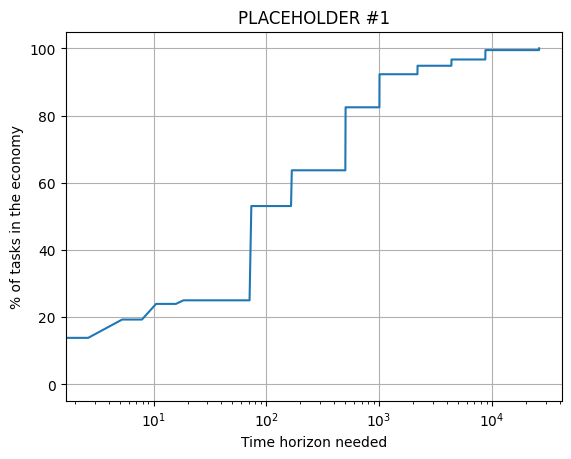

In [ ]:
# Placeholder #1
import matplotlib.pyplot as plt
import numpy as np

# Define the time range (0 to 3 years in hours)
time_range = np.linspace(0, 3 * 365.25 * 24, 10000)  # 100 points for smoothness

# Calculate the percentage of tasks for each time point
percentages = []
for time_point in time_range:
    percentage = (enriched_sample_df['ub_estimate_in_hours'] <= time_point).mean() * 100
    percentages.append(percentage)

# Create the plot
plt.plot(time_range, percentages)
plt.xscale('log')
plt.xlabel('Time horizon needed')
plt.ylabel('% of tasks in the economy')
plt.title('PLACEHOLDER #1')
plt.grid(True)
plt.show()

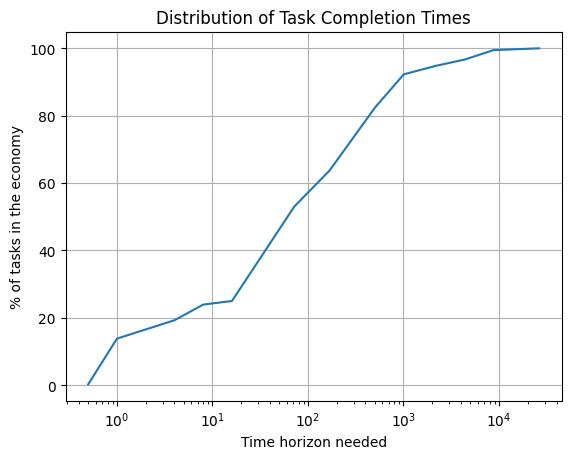

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique upper bound estimates and sort them
time_range = sorted(enriched_sample_df['ub_estimate_in_hours'].unique())

# Calculate the percentage of tasks for each time point
percentages = []
for time_point in time_range:
    percentage = (enriched_sample_df['ub_estimate_in_hours'] <= time_point).mean() * 100
    percentages.append(percentage)

# Create the plot
plt.plot(time_range, percentages)
plt.xscale('log')  # Keep the x-axis in log scale
plt.xlabel('Time horizon needed')
plt.ylabel('% of tasks in the economy')
plt.title('Distribution of Task Completion Times')  # Update the title
plt.grid(True)
plt.show()

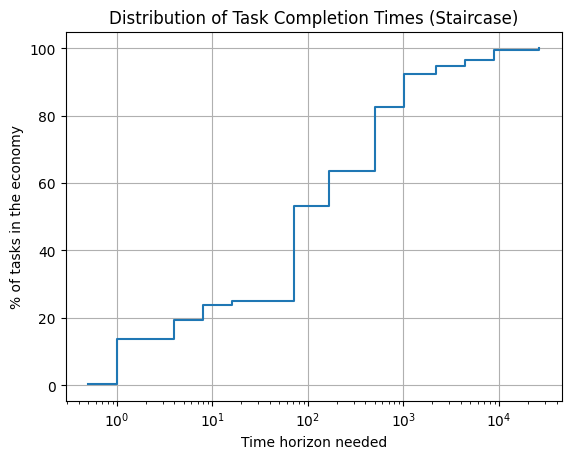

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique upper bound estimates and sort them
time_range = sorted(enriched_sample_df['ub_estimate_in_hours'].unique())

# Calculate the percentage of tasks for each time point
percentages = []
for time_point in time_range:
    percentage = (enriched_sample_df['ub_estimate_in_hours'] <= time_point).mean() * 100
    percentages.append(percentage)

# Create the staircase plot
plt.step(time_range, percentages, where='post')  # Use 'step' function with 'where='post''
plt.xscale('log')  # Keep the x-axis in log scale
plt.xlabel('Time horizon needed')
plt.ylabel('% of tasks in the economy')
plt.title('Distribution of Task Completion Times (Staircase)')  # Update the title
plt.grid(True)
plt.show()

In [ ]:
hardest_task_df = enriched_sample_df.loc[enriched_sample_df.groupby('occupation_title')['ub_estimate_in_hours'].idxmax()]
hardest_task_df

KeyError: 'Column not found: ub_estimate_in_hours'

In [ ]:
df_ground = pd.read_csv('groundtruth.csv')
len(df_ground)

45

In [ ]:
from google.colab import files

# Rename columns in df_ground to match df
df_ground = df_ground.rename(columns={"Task": "task", "Occupation": "occupation_title", "Occupation Description": "occupation_description"})

# Drop duplicates from 'df' based on merge key columns, keeping only the first occurrence
df_unique = df[['task', 'occupation_title', 'occupation_description', 'dwas']].drop_duplicates(subset=['task', 'occupation_title', 'occupation_description'], keep='first')

# Merge the two DataFrames using the specified columns
merged_df = pd.merge(df_ground, df_unique, on=['task', 'occupation_title', 'occupation_description'], how='left')

# Restore original column names in merged_df if needed
merged_df = merged_df.rename(columns={"task": "Task", "occupation_title": "Occupation", "occupation_description": "Occupation Description"})

# Access the merged DataFrame with the added 'dwas' column
merged_df.to_csv('groundtruth_with_dwas.csv', index=False)  # Save the DataFrame to a CSV file
files.download('groundtruth_with_dwas.csv')  # Download the file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

df_ground.to_csv('groundtruth_with_dwas.csv', index=False)  # Save the DataFrame to a CSV file
files.download('groundtruth_with_dwas.csv')  # Download the file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
remote_df.to_csv('task_to_estimate.csv', index=False)
files.download('task_to_estimate.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
METR = [
    [2022, '1 min'],
    [2024, '15 min'],
    [2026, '4 hours'],
    [2028, '68 hours']
]

# These are the values for the X axis